In [ ]:
!pip install transformers
!transformers-cli login
!pip install sentencepiece
!pip install demoji
!pip install pyarabic


     |████████████████████████████████| 2.6 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 37.8 MB/s 
     |████████████████████████████████| 636 kB 48.3 MB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        
Username: peterbos

# Libs

In [ ]:
import numpy as np
import pandas as pd
import re

from pyarabic import araby
from keras.preprocessing.sequence import pad_sequences
from snowballstemmer import stemmer
from nltk import wordpunct_tokenize
from nltk.stem.isri import ISRIStemmer

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, Bidirectional, BatchNormalization, Flatten, Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import demoji
demoji.download_codes() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.


# Dataset Loading

In [ ]:
data = pd.read_csv('/content/alltrain.csv')


In [ ]:
data.describe()

,Unnamed: 0
count,2212.00
mean,386.62
std,227.97
min,0.00
25%,193.00
50%,380.00
75%,578.00
max,789.00


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2212 non-null   int64 
 1   text        2212 non-null   object
 2   intent      2212 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.0+ KB


# Data Analysis

In [ ]:
np.unique(data['intent'])

array(['about bot', 'about business', 'about corona virus', 'assessment',
       'back to work', 'breathing test', 'business location',
       'comparison', 'crush', 'curfew', 'disease detection',
       'education and work', 'emergency', 'end conversation',
       'food and drinks', 'gloves', 'greeting', 'home quarantine',
       'how are you', 'infected cases', 'infection by animals',
       'kindness', 'laboratory', 'most vulnerable', 'muzzle/mask', 'no',
       'nothing identified', 'panic among the people', 'prayers',
       'precautions', 'reviews', 'smoking', 'spoken languages',
       'sterilization and disinfection', 'symptoms',
       'the evolution of the virus', 'transfer methods', 'treatment',
       'warm weather', 'yes'], dtype=object)

In [ ]:
data.intent.value_counts()

infected cases                    824
symptoms                          164
nothing identified                156
reviews                           116
precautions                       100
greeting                          100
treatment                          92
assessment                         80
transfer methods                   60
about corona virus                 60
the evolution of the virus         60
sterilization and disinfection     52
how are you                        40
business location                  32
home quarantine                    24
comparison                         20
panic among the people             16
food and drinks                    16
kindness                           16
muzzle/mask                        16
warm weather                       16
laboratory                         16
spoken languages                   16
about bot                          16
about business                     12
most vulnerable                    12
emergency   

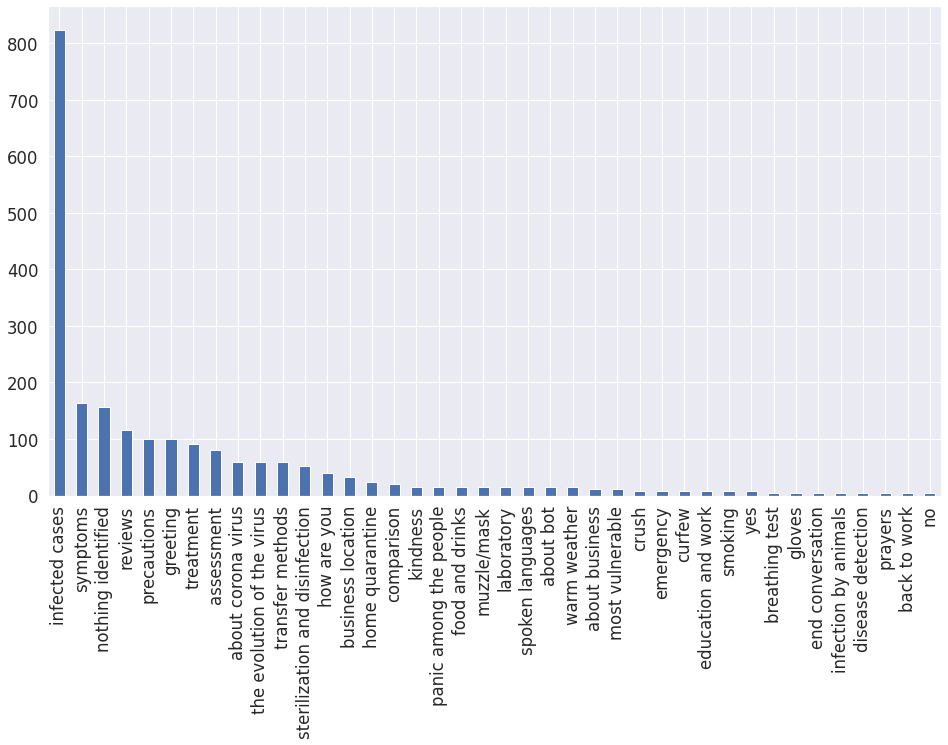

In [ ]:
data.intent.value_counts().sort_values(ascending= False).plot(kind = 'bar',figsize=(16,9))

# Preprocessing

In [ ]:
char2index = {' ': 1,'ء': 3,'آ': 4,'أ': 5,'ؤ': 6,'إ': 7,'ئ': 8,'ا': 9,'ب': 10,'ة': 11,'ت': 12,'ث': 13,'ج': 14,'ح': 15,'خ': 16,'د': 17,'ذ': 18,'ر': 19,'ز': 20,'س': 21,'ش': 22,'ص': 23,'ض': 24,'ط': 25,'ظ': 26,'ع': 27,'غ': 28,'ف': 29,'ق': 30,'ك': 31,'ل': 32,'م': 33,'ن': 34,'ه': 35,'و': 36,'ى': 37,'ي': 38,'ڤ':39}

In [ ]:
stop_file =  my_file = open("/content/list.txt", "r")
stopwords = stop_file.read().split('\n')

In [ ]:
def clean_text(string):
  string = araby.strip_tashkeel(string)
  #string = araby.normalize_alef(string)
  string = araby.normalize_teh(string)
  #string = araby.normalize_hamza(string)
  string = string = re.sub(r'ء','ا',string)
  string = re.sub(r'[0123456789]*','',string)
  string = re.sub(r'[٠,١,٢,٣,٤,٥,٦,٧,٨,٩,٪,٫,٬,٭,ٮ,ٯ,ٰ,ٱ,ٲ,ٳ,ٴ,ٵ,ٶ,ٷ,ٸ,ٹ,ٺ,ٻ,ټ,ٽ,پ,ٿ,ڀ,ځ,ڂ,ڃ,ڄ,څ,چ,ڇ,ڈ,ډ,ڊ,ڋ,ڌ,ڍ,ڎ,ڏ,ڐ,ڑ,ڒ,ړ,ڔ,ڕ,ږ,ڗ,ژ,ڙ,ښ,ڛ,ڜ,ڝ,ڞ,ڟ,ڠ,ڡ,ڢ,ڣ,ڤ,ڥ,ڦ,ڧ,ڨ,ک,ڪ,ګ,ڬ,ڭ,ڮ,گ,ڰ,ڱ,ڲ,ڳ,ڴ,ڵ,ڶ,ڷ,ڸ,ڹ,ں,ڻ,ڼ,ڽ,ھ,ڿ,ۀ,ہ,ۂ,ۃ,ۄ,ۅ,ۆ,ۇ,ۈ,ۉ,ۊ,ۋ,ی,ۍ,ێ,ۏ,ې,ۑ,ے,ۓ,۔,ە,ۖ,ۗ,ۘ,ۙ,ۚ,ۛ,ۜ,۝,۞,۟,۠,ۡ,ۢ,ۣ,ۤ,ۥ,ۦ,ۧ,ۨ,۩,۪,۫,۬,ۭ,ۮ,ۯ,۰,۱,۲,۳,۴,۵,۶,۷,۸,۹,]*','',string)
  string = re.sub(r'[…"%–_!()*-.ـ:=o«»;\[\]؛,،~?؟\u200f\ufeffـ\u200d\u200c\uf020\uf03a\uf02d\uf02e]*','',string)
  string = re.sub(r'[abcdefghijklmnopqrstuvwx×yzABCDEFGHIJKLMNOPQRSTUVWXYZ]*','',string)
  string = re.sub(r"\s+$", '',string)
  string = re.sub(r"^\s+", '',string)
  string = demoji.replace(string)
  return string	


from snowballstemmer import stemmer

def preprocess_text(text,tokenizer=wordpunct_tokenize,stemmer = stemmer('arabic'),stop_words=stopwords):
  print('old string:',text)

  # (1) Cleaning text
  text = clean_text(text)

  # (2) Tokenizing
  text = tokenizer(text)
  
  # (3) Removing stopwords
  text = [word for word in text if word not in stop_words]

  
  # (4) Stemming
  text = [stemmer.stemWord(word) for word in text]
  text = ' '.join(text)
  # (5) Removing duplicate chars
  #text = ["".join(dict.fromkeys(word)) for word in text]

  print('new string:',text)

  return text
  

In [ ]:
def digitize(string):
  return [char2index[char] for word in string for char in word]

In [ ]:
_ = data['text'].apply(preprocess_text)

old string: ما هى اعراض الاصابه بالكورونا؟
new string: هي اعراض اصابه كورونا
old string: طفشت من قعدة البيت
new string: طفش قعد بيت
old string: هل ممكن اروح المستشفى اقولهم حللولي عشان النفس تقيل
new string: ممك اروح مستشفي اقول حللول عشان نفس تقيل
old string: اعمل ايه وانا مضطر انزل الشغل و شغلي كل يوم ف مكان مختلف
new string: اعمل ايه وانا مضطر انزل شغل شغل مكان مختلف
old string: كم عدد المصابين اليوم في مصر
new string: مصاب مصر
old string: عدد الحالات في إسرائيل
new string: حال اسراييل
old string: البيان
new string: الب
old string: ما هي الأعراض
new string: اعراض
old string: ما هي اضرار فيروس كورونا
new string: اضرار يروس كور
old string: أهلا بحضرتكم تشرفنا بيكم
new string: حضر تشرف يكم
old string: سألتها ما هي علامات المرض ؟
new string: سال علاما مرض
old string: الحالات في مصر قد ايه ؟
new string: حال مصر ايه
old string: اي محافظات تم اكتشاف حلات فيها
new string: محافظا اكتشاف حلا
old string: هل مرض كورونا يؤثر على المصابين بالتهاب في الرئة؟
new string: مرض كور يوثر مصاب تهاب ريه
o

In [ ]:
le = LabelEncoder()
labels = le.fit_transform(data['intent'])

# Pytorch

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
# Load the tokenizer.
tokenizer = BertTokenizer.from_pretrained("asafaya/bert-base-arabic")
# Load the model.


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in data['text']:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', data['text'][0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  ما هى اعراض الاصابه بالكورونا؟
Token IDs: tensor([    2,  1809,  6985,  6780,  2880,  4055,  3746, 13003,  1006,   221,
            3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size],generator=torch.Generator().manual_seed(87))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,990 training samples
  222 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("asafaya/bert-base-arabic", num_labels = 40)

# Tell pytorch to run this model on the GPU.
_=model.cuda()

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-ar

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (32000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        #model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels).values()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels).values()
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     63.    Elapsed: 0:00:22.

  Average training loss: 2.14
  Training epcoh took: 0:00:34

Running Validation...
  Accuracy: 0.68
  Validation Loss: 1.39
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     63.    Elapsed: 0:00:22.

  Average training loss: 1.09
  Training epcoh took: 0:00:34

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.88
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     63.    Elapsed: 0:00:22.

  Average training loss: 0.57
  Training epcoh took: 0:00:34

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.60
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     63.    Elapsed: 0:00:22.

  Average training loss: 0.35
  Training epcoh took: 0:00:34

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.52
  Validation took: 0:00:01

Training complete!
Total tr

In [ ]:

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,2.14,1.39,0.68,0:00:34,0:00:01
2,1.09,0.88,0.79,0:00:34,0:00:01
3,0.57,0.60,0.88,0:00:34,0:00:01
4,0.35,0.52,0.89,0:00:34,0:00:01


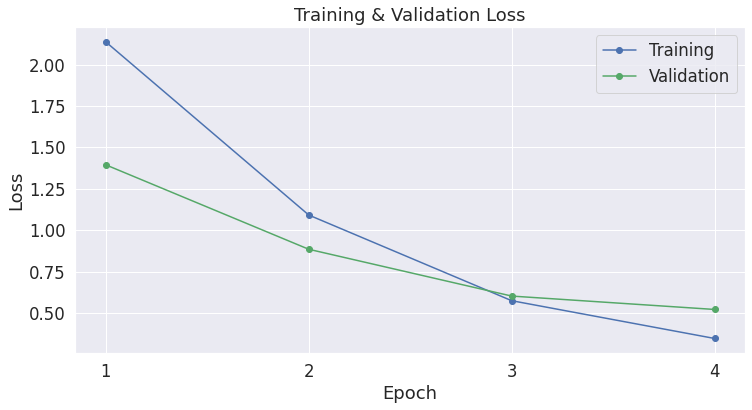

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_4.bin')

# TEST

In [ ]:
test_data = pd.read_csv('/content/alltest.csv')

In [ ]:
model = BertForSequenceClassification.from_pretrained("asafaya/bert-base-arabic", num_labels = 40)
#checkpoint = torch.load('/content/drive/MyDrive/model/pytorch_model.bin')
if torch.device("cpu") != device:
  checkpoint = torch.load('/content/drive/MyDrive/model_4.bin')
else:
  checkpoint = torch.load('/content/drive/MyDrive/model_4.bin', map_location='cpu')
model.load_state_dict(checkpoint)
model = model.to(device)

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-ar

In [ ]:
# Create sentence and label lists
sentences = test_data.text.values
#del labels
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 1  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  #label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(np.argmax(logits, axis=1)[0])
  #true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [ ]:
test_data

,Unnamed: 0,text,intent
0,681,السودان,infected cases
1,730,ماهي الفحوصات المطلوبه لمعرفه وجود الفيروس,disease detection
2,157,وفايات,infected cases
3,428,ما إعداد مصابة بهتيم,infected cases
4,377,برافو عليك يا نميسة رفعتي رأسنا والل ه شطورة,reviews
...,...,...,...
947,327,لكل القلش بتاع ولسه مجاوبتيش في سؤالك,nothing identified
948,339,؟ والتهاب البيوت الأنفية المفروض مسبب كارونا,symptoms
949,586,لعدد والاصابات فى ليبيا,infected cases
950,736,الانديه وبين انفلونزا والكورونا,comparison


In [ ]:
s = pd.DataFrame(le.inverse_transform(predictions)).reset_index().rename(columns={0:'intent'})

In [ ]:
sum(s['intent'] == test_data['intent'])

689

In [ ]:
689/952 

0.7237394957983193